# CDSDS 542 Deep Learning for Data Science - Discussion 13

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DL4DS/fa2026_discussions/blob/main/discussion_13.ipynb)

**Task**: Fool a pre-trained ResNet-18 by adding minimal perturbations to images!

**Goal**:
1. Smallest Perturbation: successfully attack with minimum ε.
2. Invisible Attack: Human can't easily tell the difference.

In [ ]:
# module
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# load pretrained ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model = model.to(device)
model.eval()
print("ResNet-18 loaded")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 241MB/s]


ResNet-18 loaded


In [ ]:
# download ImageNet class labels
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(LABELS_URL)
imagenet_classes = response.text.strip().split('\n')
print(f"Loaded {len(imagenet_classes)} ImageNet classes")
print(f"Example classes: {imagenet_classes[281]}, {imagenet_classes[207]}, {imagenet_classes[859]}")

Loaded 1000 ImageNet classes
Example classes: tabby, golden retriever, toaster


## Part 1: Load Sample Images

We'll use some classic test images. Feel free to add your own!

In [ ]:
# @title
# sample image URLs
IMAGE_URLS = {
    'dog': 'https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg',
    'car': 'https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04285008_sports_car.JPEG',
}

# image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# normalization values for ImageNet
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

def normalize(x):
    return (x - mean) / std

def denormalize(x):
    return x * std + mean

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    return img, img_tensor

def predict(model, img_tensor): # get model prediction
    with torch.no_grad():
        output = model(normalize(img_tensor))
        probs = F.softmax(output, dim=1)
        top5_probs, top5_idx = probs.topk(5)
    return top5_idx[0], top5_probs[0]

def show_prediction(img_tensor, title="Prediction"):
    top5_idx, top5_probs = predict(model, img_tensor)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # show image
    img_np = img_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
    ax1.imshow(np.clip(img_np, 0, 1))
    ax1.set_title(title)
    ax1.axis('off')

    # show predictions
    labels = [imagenet_classes[idx] for idx in top5_idx.cpu()]
    probs = top5_probs.cpu().numpy()
    y_pos = np.arange(5)
    ax2.barh(y_pos, probs, color='steelblue')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.set_xlabel('Confidence')
    ax2.set_title('Top-5 Predictions')
    ax2.set_xlim(0, 1)
    ax2.invert_yaxis()
    plt.tight_layout()
    plt.show()

    return top5_idx[0].item(), imagenet_classes[top5_idx[0]]

def visualize_attack(original, adversarial, title="Attack"):

    perturbation = adversarial - original
    fig, axes = plt.subplots(2, 3, figsize=(14, 9))

    # original
    orig_np = original.squeeze().cpu().permute(1, 2, 0).numpy()
    axes[0, 0].imshow(np.clip(orig_np, 0, 1))
    orig_pred_idx, orig_pred_probs = predict(model, original)
    axes[0, 0].set_title(f"Original\n{imagenet_classes[orig_pred_idx[0]]}\n({orig_pred_probs[0]:.2%})")
    axes[0, 0].axis('off')

    # perturbation
    pert_np = perturbation.squeeze().cpu().permute(1, 2, 0).numpy()
    pert_amplified = (pert_np - pert_np.min()) / (pert_np.max() - pert_np.min() + 1e-8)
    axes[0, 1].imshow(pert_amplified)
    axes[0, 1].set_title(f"Perturbation (amplified)\nL∞ = {perturbation.abs().max():.4f}")
    axes[0, 1].axis('off')

    # adversarial
    adv_np = adversarial.squeeze().cpu().permute(1, 2, 0).numpy()
    axes[0, 2].imshow(np.clip(adv_np, 0, 1))
    adv_pred_idx, adv_pred_probs = predict(model, adversarial)
    axes[0, 2].set_title(f"Adversarial\n{imagenet_classes[adv_pred_idx[0]]}\n({adv_pred_probs[0]:.2%})")
    axes[0, 2].axis('off')

    labels_orig = [imagenet_classes[idx] for idx in orig_pred_idx.cpu()]
    axes[1, 0].barh(range(5), orig_pred_probs.cpu().numpy(), color='green')
    axes[1, 0].set_yticks(range(5))
    axes[1, 0].set_yticklabels(labels_orig)
    axes[1, 0].set_xlim(0, 1)
    axes[1, 0].invert_yaxis()
    axes[1, 0].set_xlabel('Confidence')

    axes[1, 1].text(0.5, 0.5, f'→ Attack →', ha='center', va='center', fontsize=20)
    axes[1, 1].axis('off')

    labels_adv = [imagenet_classes[idx] for idx in adv_pred_idx.cpu()]
    axes[1, 2].barh(range(5), adv_pred_probs.cpu().numpy(), color='red')
    axes[1, 2].set_yticks(range(5))
    axes[1, 2].set_yticklabels(labels_adv)
    axes[1, 2].set_xlim(0, 1)
    axes[1, 2].invert_yaxis()
    axes[1, 2].set_xlabel('Confidence')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


=== DOG ===


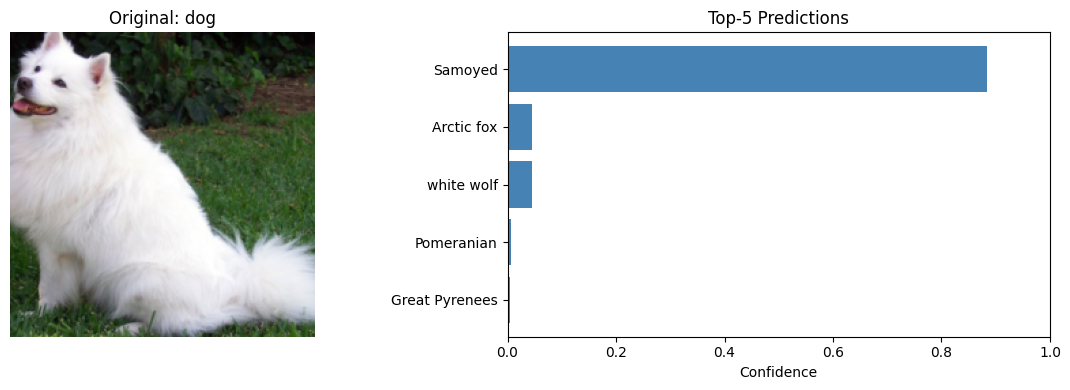

Predicted: Samoyed (class 258)

=== CAR ===


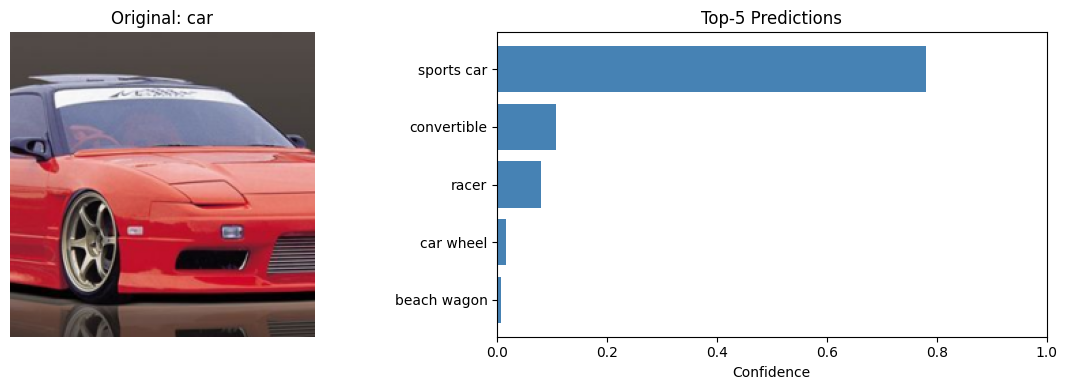

Predicted: sports car (class 817)


In [ ]:
# Load and display all sample images
images = {}
for name, url in IMAGE_URLS.items():
    try:
        pil_img, img_tensor = load_image_from_url(url)
        images[name] = img_tensor
        print(f"\n=== {name.upper()} ===")
        pred_idx, pred_label = show_prediction(img_tensor, f"Original: {name}")
        print(f"Predicted: {pred_label} (class {pred_idx})")
    except Exception as e:
        print(f"Failed to load {name}: {e}")

## Part 2: Attack - Fast Gradient Sign Method (FGSM)


$$x_{adv} = x + \epsilon \cdot \text{sign}(\nabla_x L(\theta, x, y))$$

The idea: move the input in the direction that **increases** the loss (opposite of gradient descent on weights)

In [ ]:
def fgsm_attack(model, image, label, epsilon):

    image_adv = image.clone().detach().requires_grad_(True)

    # forward pass
    output = model(normalize(image_adv))

    # calculate loss
    loss = F.cross_entropy(output, label)

    # backward pass
    model.zero_grad()
    loss.backward()

    # get gradient sign
    grad_sign = image_adv.grad.sign()

    # TODO: Implement the perturbation
    # create perturbation
    perturbation = __fill__

    # add perturbation to image
    adv_image = image_adv + perturbation

    # clip to valid range [0, 1]
    adv_image = torch.clamp(adv_image, 0, 1)

    return adv_image.detach()

In [ ]:
# TODO: test the output
test_image = images['dog']
true_label = torch.tensor([258]).to(device)
epsilons = [0.0, 0.01, 0.03, 0.05, 0.1, 0.2]


for eps in epsilons:
    adv_image = fgsm_attack(model, test_image, true_label, eps)
    pred_idx, pred_probs = predict(model, adv_image)

    # check if attack succeeded
    success = pred_idx[0].item() != true_label.item()
    status = "Fooled" if success else "Correct"

    print(f"ε = {eps:.2f}: {imagenet_classes[pred_idx[0]]} ({pred_probs[0]:.2%}) {status}")

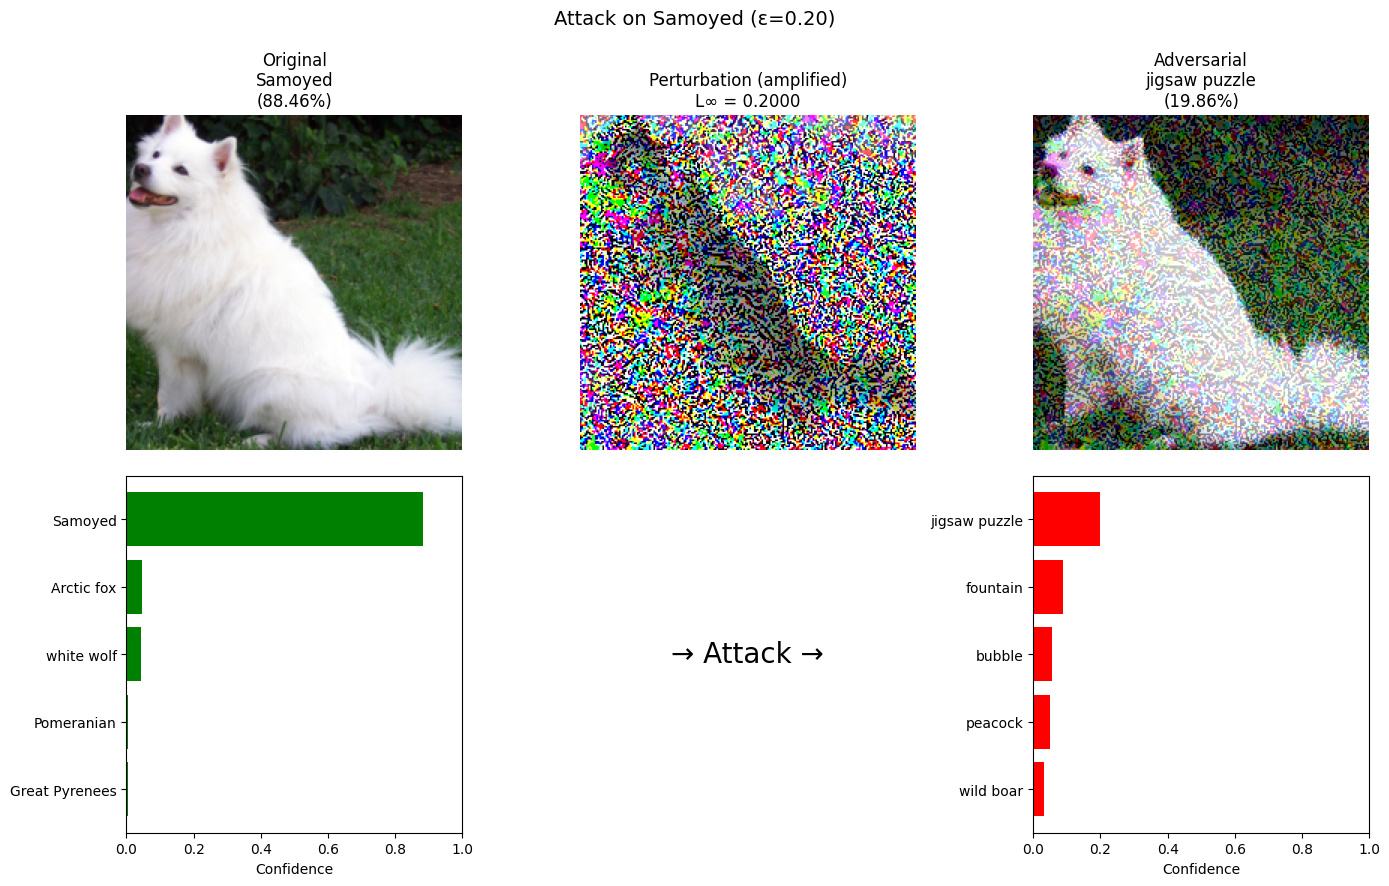

In [ ]:
# visualize attack with epsilon = 0.03
adv_cat = fgsm_attack(model, images['dog'], true_label, epsilon=0.20)
visualize_attack(images['dog'], adv_cat, "Attack on Samoyed (ε=0.20)")

## Part 3: Attack Stronger - Projected Gradient Descent (PGD)

Multiple small steps instead of one big step:

$$x^{(t+1)} = \Pi_{x+S} \left( x^{(t)} + \alpha \cdot \text{sign}(\nabla_x L) \right)$$

Where $\Pi$ projects back into the ε-ball around original image

In [ ]:
def pgd_attack(model, image, label, epsilon, alpha, num_iter):

    adv_image = image.clone().detach()

    for i in range(num_iter):
        adv_image.requires_grad_(True)

        # forward pass
        output = model(normalize(adv_image))
        loss = F.cross_entropy(output, label)

        # backward pass
        model.zero_grad()
        loss.backward()

        # update with small step
        with torch.no_grad():
            adv_image = adv_image + alpha * adv_image.grad.sign()

            # project: keep perturbation within epsilon ball
            perturbation = torch.clamp(adv_image - image, -epsilon, epsilon)
            adv_image = torch.clamp(image + perturbation, 0, 1)

    return adv_image.detach()

FGSM Result:
  Prediction: Arctic fox

PGD Result:
  Prediction: lynx


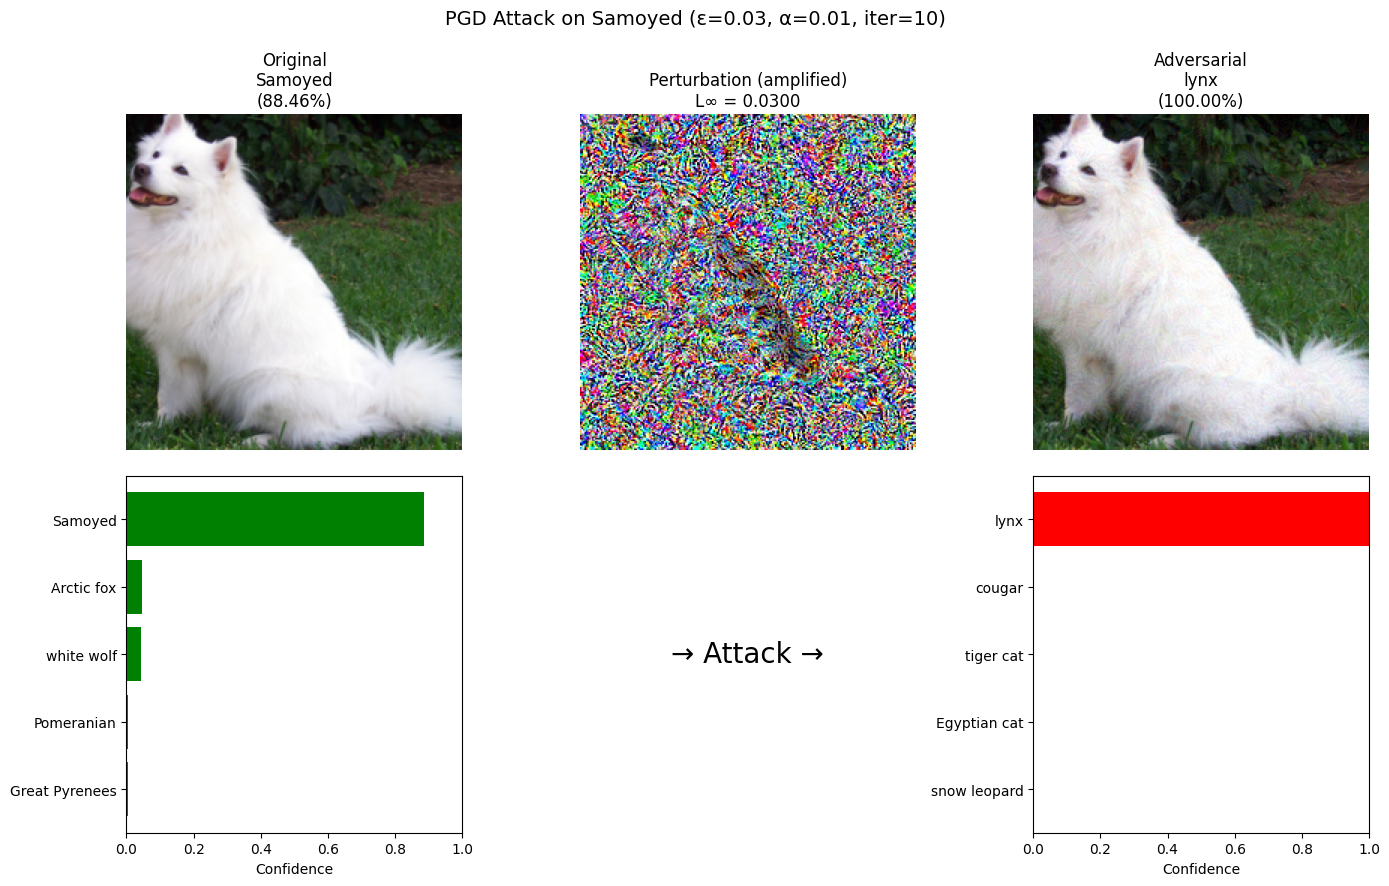

In [ ]:
epsilon = 0.03
alpha = 0.01
num_iter = 10

adv_fgsm = fgsm_attack(model, images['dog'], true_label, epsilon)
adv_pgd = pgd_attack(model, images['dog'], true_label, epsilon, alpha, num_iter)

print("FGSM Result:")
fgsm_pred, _ = predict(model, adv_fgsm)
print(f"  Prediction: {imagenet_classes[fgsm_pred[0]]}")

print("\nPGD Result:")
pgd_pred, _ = predict(model, adv_pgd)
print(f"  Prediction: {imagenet_classes[pgd_pred[0]]}")

visualize_attack(images['dog'], adv_pgd, f"PGD Attack on Samoyed (ε={epsilon}, α={alpha}, iter={num_iter})")

## Part 4: Targeted Attack

Instead of just fooling the model, we can also make it predict a **specific wrong class**!

**Hint**: Instead of maximizing loss for true label, minimize loss for target label

In [ ]:
from ipywidgets import Dropdown, interactive_output, VBox

target_dropdown = Dropdown(
    options=[(name, idx) for idx, name in enumerate(imagenet_classes)],
    description='Target Class:',
    value=954,
    layout={'width': '400px'}
)

def show_target(target):
    print(f"Selected Target Index: {target}")
    print(f"Target Class Name: {imagenet_classes[target]}")

output = interactive_output(show_target, {'target': target_dropdown})
VBox([target_dropdown, output])

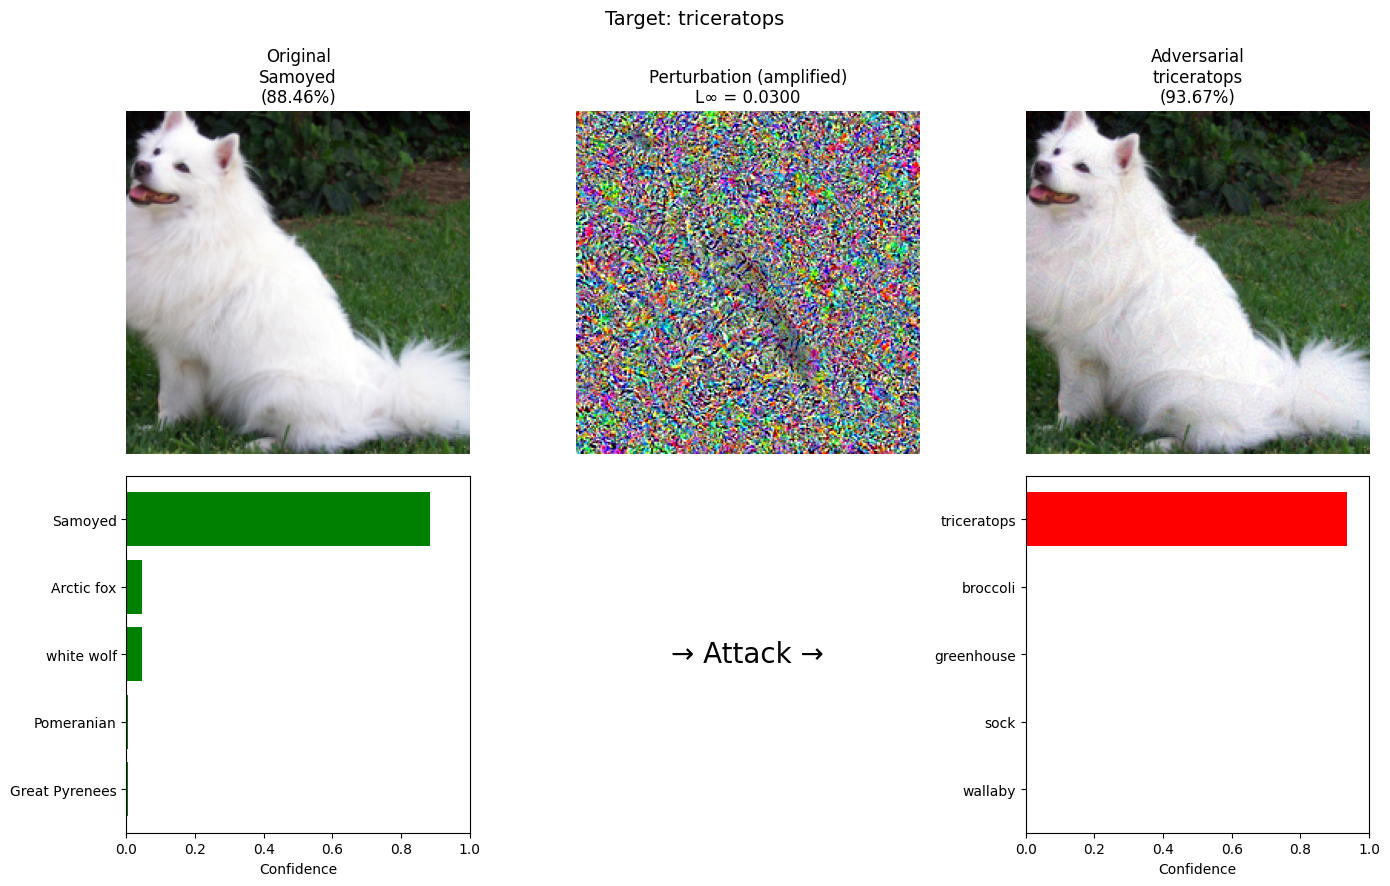

In [ ]:
# Try to turn a Samoyed into another class

# may need higher epsilon and multiple iterations
def targeted_pgd_attack(model, image, target_label, epsilon, alpha, num_iter):
    adv_image = image.clone().detach()

    for i in range(num_iter):
        adv_image.requires_grad_(True)
        output = model(normalize(adv_image))
        loss = F.cross_entropy(output, target_label)

        model.zero_grad()
        loss.backward()

        with torch.no_grad():

            # How should we change the loss for targeted attack?
            # we want to DECREASE the loss for the target class (gradient move toward target, not away from true)
            # so we use subtract here instead of add

            adv_image = adv_image - alpha * adv_image.grad.sign()
            perturbation = torch.clamp(adv_image - image, -epsilon, epsilon)
            adv_image = torch.clamp(image + perturbation, 0, 1)

    return adv_image.detach()

def run_targeted_attack(image, epsilon=0.1, alpha=0.01, num_iter=3):

    target = torch.tensor([target_dropdown.value]).to(device)
    adv = targeted_pgd_attack(model, image, target, epsilon, alpha, num_iter)
    visualize_attack(image, adv, f"Target: {imagenet_classes[target.item()]}")

run_targeted_attack(images['dog'])

**Neural networks are surprisingly fragile** to small, imperceptible perturbations. This has real implications for **AI safety** (self-driving cars, medical diagnosis, etc.)

### Reference:
- [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) (Goodfellow et al., 2014)
- [Towards Deep Learning Models Resistant to Adversarial Attacks](https://arxiv.org/abs/1706.06083) (Madry et al., 2017)
- [A Comprehensive Review of Adversarial Attacks and Defense Strategies in Deep Neural Networks](https://www.researchgate.net/publication/391789804_A_Comprehensive_Review_of_Adversarial_Attacks_and_Defense_Strategies_in_Deep_Neural_Networks) (Abomakhelb et al., 2025)